<h2>Analisi comparativa dei metodi di dosaggio degli anticorpi anti recettore del TSH</h2>
<h3>Metodo Routine:<h3>
<ul>
<li>Brahms Trak Human con metodica LIA </li>
<li><small>Metodo Siemens XPi TSI Assay chemiluminescenza Immulite 2000</small></li>
</ul>
<h3>Metodo di comparazione Thermophisher: anti TSH-R Elia su Immunocap 250</h3>

Analisi dei dati effettuata con la suite CONTINUUM ANALITICS https://www.continuum.io/

basata sui seguenti moduli python:
<ul>
<li>Pandas: per la gestione dei dati e le analisi di base </li>
<li> Matplotlib: per i grafici di base</li>
<li>Seaborn per grafici avanzati</li>
<li>Statmodels e scipy per le analisi avanzate</li>
</ul>

** tutti i software utilizzati sono open source**

In [41]:
%matplotlib inline
#importo le librerie
import pandas as pd
import os
from __future__ import print_function,division
import numpy as np
import seaborn as sns
os.environ["NLS_LANG"] = "ITALIAN_ITALY.UTF8"

<h4>Importazione del file con i dati </h4>

In [42]:
#importo il file con i dati
path=r"D:\d\05 Lavscien\autoimmunita\corr_thibya\compar_thibya_brahms.csv"
database=pd.read_csv(path,sep=';',usecols=[1, 2, 3,4,5])#colonne da utilizzare
database['valore_cap']=database['valore_cap'].apply(lambda x: round(x,2))
database.drop(['codificato','accettazione'],axis=1,inplace=True)
database.tail(6)


,campione,valore_cap,valore_rut
68,9430601678,2.30,0.1
69,9430600613,13.82,14.2
70,9430601997,2.52,0.1
71,9430600787,2.34,0.6
72,9430601111,2.54,0.8
73,9430601066,3.07,1.2


Varibili d'ambiete in comune

In [43]:
#variabili d'ambiente comuni
cutoff_cap=2.9 #tre 2.9 r 3.3 dubbi
#cutoff_cap=3.3
cutoff_rout=1 #brahms 1-1.5 dubbi
METODO_ROUTINE="Brahms Trak Human LIA"
#METODO_ROUTINE="Siemens Immulite 2000 Chemil."
CAP="Thermo Fisher ELIA anti-TSH-R Cap250 "

<h3>Aggiungo due colonne con pos neg in base al cut-off</h3>

In [44]:


database['cap_PN']=(database['valore_cap']>=cutoff_cap)
database['rut_PN']=(database['valore_rut']>=cutoff_rout)
database['cap_PN'].replace([True,False],['Pos','Neg'],inplace=True)
database['rut_PN'].replace([True,False],['Pos','Neg'],inplace=True)
database.head()

,campione,valore_cap,valore_rut,cap_PN,rut_PN
0,9430598753,1.77,0.4,Neg,Neg
1,9430598217,2.46,0.3,Neg,Neg
2,9430598216,2.26,0.8,Neg,Neg
3,9430598758,2.57,2.2,Neg,Pos
4,9430598331,2.29,0.4,Neg,Neg


In [45]:
database.describe()

,campione,valore_cap,valore_rut
count,7.400000e+01,74.000000,74.000000
mean,9.430545e+09,5.334189,3.548378
std,1.595923e+05,8.101052,8.094432
min,9.430089e+09,1.770000,0.100000
25%,9.430599e+09,2.492500,0.400000
50%,9.430600e+09,2.905000,0.600000
75%,9.430601e+09,3.610000,1.400000
max,9.430602e+09,58.450000,40.000000


<h4>Calcolo la tabella delle frequenze</h4>
<font color='red'> **modulo utilizzato scipy.stat** </font>  http://docs.scipy.org/doc/scipy/reference/stats.html

In [46]:
#sci.py moduli
from scipy.stats import chi2_contingency, fisher_exact
pd.crosstab(database.cap_PN,database.rut_PN)

rut_PN,Neg,Pos
cap_PN,,
Neg,32,5
Pos,18,19


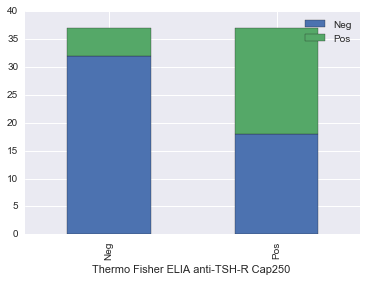

In [47]:
ax=pd.crosstab(database.cap_PN,database.rut_PN).plot(kind='bar',stacked=True, )
ax.legend(['Neg','Pos'])
ax.set_xlabel(CAP)

<h4> Test chi quadrato</h4>

In [48]:
# test chi square
chi2, pvalue, dof, ex = chi2_contingency(pd.crosstab(database.cap_PN,database.rut_PN))
print ('valore di p:{}'.format(pvalue))

valore di p:0.00124545445958


<h4> Test esatto di Fisher</h4>

In [49]:
# test esatto di Fisher
oddsratio, pvalue =fisher_exact(pd.crosstab(database.cap_PN,database.rut_PN))
print ('valore di p:{}'.format(pvalue))

valore di p:0.00101091533838


<h3>test corretto per questo caso è il test di McNemar:</h3>
**test non parametrico dati appaiati risposte nominali binarie**
<h4> Test esatto McNemar (per la dipendenza delle variabili)</h4>
<font color='red'> **modulo utilizzato statsmodels** </font>  http://statsmodels.sourceforge.net/stable/index.html

In [50]:
from statsmodels.sandbox.stats.runs import mcnemar
stat,p=mcnemar(pd.crosstab(database.cap_PN,database.rut_PN))
print("valore di p:{}".format(p))

valore di p:0.0106220245361


-

<h2> Analisi della regressione</h2>

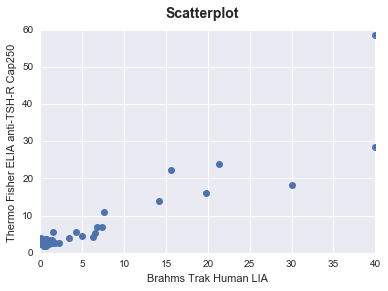

In [51]:
# grafico di dispersione 
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Scatterplot', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel(METODO_ROUTINE)
ax.set_ylabel(CAP)
ax.plot(database.valore_rut,database.valore_cap,'o')
plt.show()

** eseguiamo ora lo studio di regressione con tre modelli diversi**

<font color='red'>Moduli statmodels e scipy </font>

In [52]:
# con statmodel : regressione minimi quadrati
##res_ols = sm.OLS(y, statsmodels.tools.add_constant(X)).fit() per vecchia versione
import statsmodels.api as sm
#sm.OLS(Y,X)
X = sm.add_constant(database.valore_rut )
modello_minquad=sm.OLS(database.valore_cap,X)
regressione_minquad=modello_minquad.fit()
regressione_minquad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             valore_cap   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     390.4
Date:                Fri, 30 Sep 2016   Prob (F-statistic):           8.50e-31
Time:                        12:21:53   Log-Likelihood:                -190.49
No. Observations:                  74   AIC:                             385.0
Df Residuals:                      72   BIC:                             389.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0711      0.409      5.064      0.000       1.256       2.886
valore_rut     0.9196      0.047     19.760      0.000       0.827       1.012
==============================================================================
Omnibus:                       67.461   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1368.471
Skew:                           2.121   Prob(JB):                    6.92e-298
Kurtosis:                      23.636   Cond. No.                         9.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# con statmodel : regressione robusta (Robust Linear Model)
X = sm.add_constant(database.valore_rut)
modello=sm.RLM(database.valore_cap,X)
regressione_robusta=modello.fit()
regressione_robusta.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:             valore_cap   No. Observations:                   74
Model:                            RLM   Df Residuals:                       72
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 30 Sep 2016                                         
Time:                        12:21:53                                         
No. Iterations:                    50                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3419      0.103     22.720      0.000       2.140       2.544
valore_rut     0.6943      0.012     59.191      0.000       0.671       0.717
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

[(0, 50.0)]

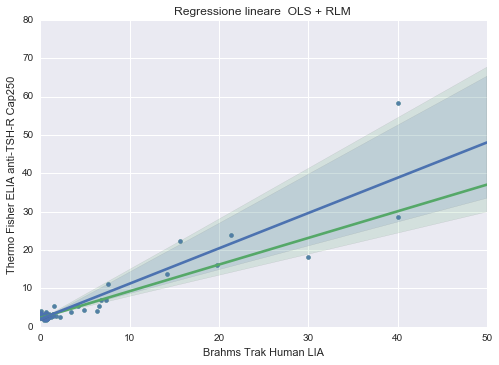

In [54]:
#importo la librearia seborn per una migliore visualizzazione grafica

sns.set(color_codes=True)
ax = sns.regplot(x=database.valore_rut,y=database.valore_cap,  color="g",robust=True)
ax = sns.regplot(x=database.valore_rut,y=database.valore_cap,  color="b")
ax.set_title('Regressione lineare  OLS + RLM ')
ax.set_xlabel(METODO_ROUTINE)
ax.set_ylabel(CAP)
ax.set(ylim=(0, None))
ax.set(xlim=(0, None))

[(0, 8)]

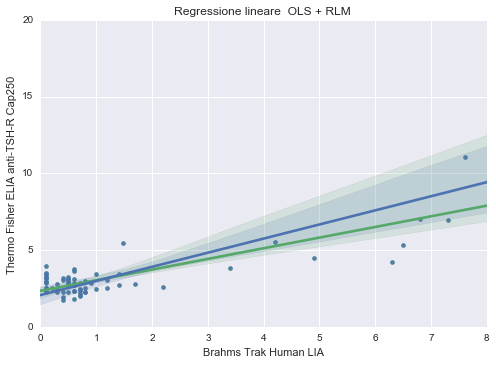

In [55]:
sns.set(color_codes=True)
ax2 = sns.regplot(x=database.valore_rut,y=database.valore_cap,  color="g",robust=True)
ax2 = sns.regplot(x=database.valore_rut,y=database.valore_cap,  color="b")
ax2.set_title('Regressione lineare  OLS + RLM ')
ax2.set_xlabel(METODO_ROUTINE)
ax2.set_ylabel(CAP)
ax2.set(ylim=(0, 20))
ax2.set(xlim=(0, 8))

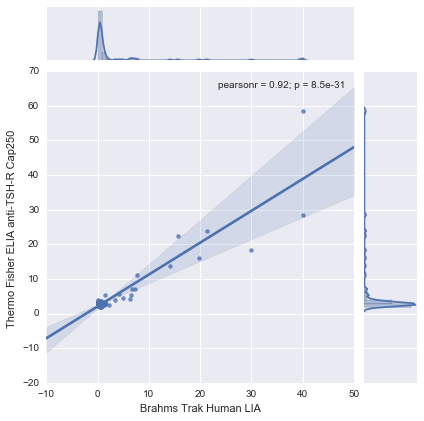

In [56]:
ax=sns.jointplot(x=database.valore_rut,y=database.valore_cap, kind="reg");
ax.set_axis_labels(METODO_ROUTINE,CAP)

** Ortogonal Distance Regression (Deming Regression)**

In [57]:
# regressione ODR  (ortogonal distance regression Deming)
import scipy.odr as odr
#modello di fitting
def funzione(B,x):
    return B[0]*x+B[1]
linear= odr.Model(funzione)
variabili=odr.Data(database.valore_rut,database.valore_cap)
regressione_ortogonale=odr.ODR(variabili,linear,beta0=[1., 2.])
output=regressione_ortogonale.run()
#print (odr.Model)
output.pprint()

Beta: [ 1.00088365  1.78267543]
Beta Std Error: [ 0.04851125  0.41899546]
Beta Covariance: [[ 0.00043625 -0.00154797]
 [-0.00154797  0.03254372]]
Residual Variance: 5.39450361153
Inverse Condition #: 0.109803542662
Reason(s) for Halting:
  Sum of squares convergence


In [58]:
print("coefficente angolare: {ang}, Intercetta: {int}".format(ang=output.beta[0],int=output.beta[1]))

coefficente angolare: 1.00088364976, Intercetta: 1.78267543073


<h4>Bias</h4>

In [59]:
database_b=database
database_b['bias']=database['valore_rut']-database['valore_cap']
database_b.head(5)

,campione,valore_cap,valore_rut,cap_PN,rut_PN,bias
0,9430598753,1.77,0.4,Neg,Neg,-1.37
1,9430598217,2.46,0.3,Neg,Neg,-2.16
2,9430598216,2.26,0.8,Neg,Neg,-1.46
3,9430598758,2.57,2.2,Neg,Pos,-0.37
4,9430598331,2.29,0.4,Neg,Neg,-1.89


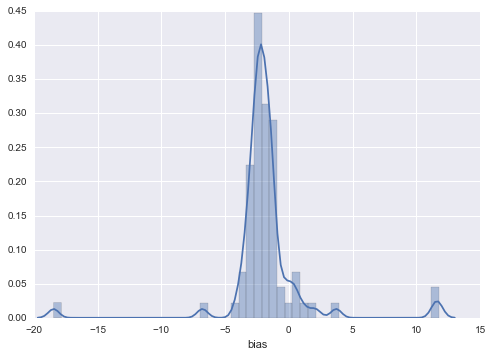

In [60]:
sns.distplot(database_b.bias)

In [61]:
database.describe()

,campione,valore_cap,valore_rut,bias
count,7.400000e+01,74.000000,74.000000,74.000000
mean,9.430545e+09,5.334189,3.548378,-1.785811
std,1.595923e+05,8.101052,8.094432,3.262094
min,9.430089e+09,1.770000,0.100000,-18.450000
25%,9.430599e+09,2.492500,0.400000,-2.635000
50%,9.430600e+09,2.905000,0.600000,-2.125000
75%,9.430601e+09,3.610000,1.400000,-1.387500
max,9.430602e+09,58.450000,40.000000,11.760000


Creo colonne con Positivo negativo dubbio in base ai cut off secificati dalle ditte

In [62]:
def discret_cap(x):
    if x<2.9:
        return 'N'
    elif x>=3.3:
        return 'P'
    else:
        return 'D'

def discret_bra(x):
    if x<1:
        return 'N'
    elif x>=1.5:
        return 'P'
    else:
        return 'D'
    
database['cap_PND']=database['valore_cap'].apply(discret_cap)
database['rut_PND']=database['valore_rut'].apply(discret_bra)

In [63]:
database.head(12)

,campione,valore_cap,valore_rut,cap_PN,rut_PN,bias,cap_PND,rut_PND
0,9430598753,1.77,0.4,Neg,Neg,-1.37,N,N
1,9430598217,2.46,0.3,Neg,Neg,-2.16,N,N
2,9430598216,2.26,0.8,Neg,Neg,-1.46,N,N
3,9430598758,2.57,2.2,Neg,Pos,-0.37,N,P
4,9430598331,2.29,0.4,Neg,Neg,-1.89,N,N
5,9430599124,1.80,0.6,Neg,Neg,-1.20,N,N
6,9430599592,2.24,0.5,Neg,Neg,-1.74,N,N
7,9430599586,2.87,0.6,Neg,Neg,-2.27,N,N
8,9430600502,23.83,21.3,Pos,Pos,-2.53,P,P
9,9430600789,6.98,7.3,Pos,Pos,0.32,P,P


In [64]:
pd.crosstab(database.cap_PND,database.rut_PND)

rut_PND,D,N,P
cap_PND,,,
D,1,13,0
N,3,32,2
P,3,5,15


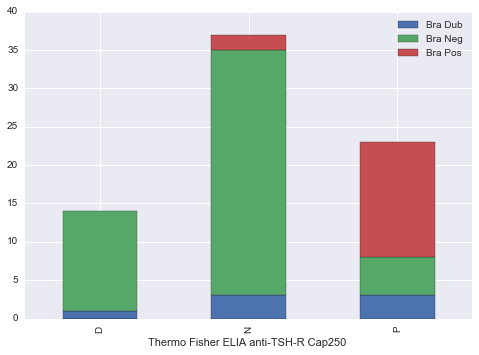

In [65]:
ax=pd.crosstab(database.cap_PND,database.rut_PND).plot(kind='bar',stacked=True, )
ax.legend(['Bra Dub','Bra Neg','Bra Pos'])
ax.set_xlabel(CAP)

**Creo una colonna che assume valore positivo solo nel caso in cui i due metodi abbiano dato valore opposto N con P o vieceversa)**

In [66]:
def no_match(x):
    if (x['cap_PND']==x['rut_PND']or x['cap_PND']=='D' or x['rut_PND']=='D'):
        return 0
    else:
        return 1
        

#df.apply(lambda row: my_test(row['a'], row['c']), axis=1)

database['mismatch']=database.apply(no_match,axis=1)
#database['valore_cap'].apply(discret_cap)
per_disc=round(100*database['mismatch'].sum()/database['mismatch'].count(),2)
database.head(20)



,campione,valore_cap,valore_rut,cap_PN,rut_PN,bias,cap_PND,rut_PND,mismatch
0,9430598753,1.77,0.4,Neg,Neg,-1.37,N,N,0
1,9430598217,2.46,0.3,Neg,Neg,-2.16,N,N,0
2,9430598216,2.26,0.8,Neg,Neg,-1.46,N,N,0
3,9430598758,2.57,2.2,Neg,Pos,-0.37,N,P,1
4,9430598331,2.29,0.4,Neg,Neg,-1.89,N,N,0
5,9430599124,1.80,0.6,Neg,Neg,-1.20,N,N,0
6,9430599592,2.24,0.5,Neg,Neg,-1.74,N,N,0
7,9430599586,2.87,0.6,Neg,Neg,-2.27,N,N,0
8,9430600502,23.83,21.3,Pos,Pos,-2.53,P,P,0
9,9430600789,6.98,7.3,Pos,Pos,0.32,P,P,0


In [73]:
print("classificazioni deiverse: {} su un totale di {}".format(database['mismatch'].sum(),database['mismatch'].count()))
print(" pecentuale di discordanza e dello {}%".format(per_disc))

classificazioni deiverse: 7 su un totale di 74
 pecentuale di discordanza e dello 9.46%
